In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os

In [ ]:
# Mapeo exacto según la imagen
style_mapping = {
    'rock': 'Dramatic',
    'street': 'Creative',
    'ethnic': 'Natural',
    'dressy': 'Elegant',
    'mode': 'Magnetic',
    'gal': 'Romantic',
    'natural': 'Natural',
    'casual': 'Natural',
    'feminine': 'Romantic',
    'girlish': 'Romantic',
    'conservative': 'Traditional',
    'retro': 'Creative'
}

base_dir="/content/drive/MyDrive/FashionStyle14_v1"

def convert_csv(input_file, output_file):
      # Rutas completas
    input_path = os.path.join(base_dir, input_file)
    output_path = os.path.join(base_dir, output_file)

    df = pd.read_csv(input_path, sep='\r', header=None, names=['file_path'], engine='python')

    # Extraer nombre de carpeta y aplicar mapeo
    df['label'] = df['file_path'].apply(
        lambda x: style_mapping.get(x.split('/')[1].lower().replace('.', ''), None)
    )

    # Eliminar filas con estilos no mapeados
    df = df.dropna(subset=['label'])

    # Guardar nuevo CSV
    df.to_csv(output_path, index=False)
    print(f"Convertido: {input_file} -> {output_file}")
    print(f"Total muestras: {len(df)}")
    print(f"Distribución por estilo:\n{df['label'].value_counts().sort_index()}")

# Convertir todos los archivos
convert_csv('train.csv', 'train_7styles.csv')
convert_csv('test.csv', 'test_7styles.csv')
convert_csv('val.csv', 'val_7styles.csv')

Convertido: train.csv -> train_7styles.csv
Total muestras: 5503
Distribución por estilo:
label
Creative       1225
Dramatic        501
Elegant         588
Magnetic        369
Natural        1058
Romantic       1172
Traditional     590
Name: count, dtype: int64
Convertido: test.csv -> test_7styles.csv
Total muestras: 3520
Distribución por estilo:
label
Creative        719
Dramatic        286
Elegant         310
Magnetic        196
Natural         614
Romantic       1024
Traditional     371
Name: count, dtype: int64
Convertido: val.csv -> val_7styles.csv
Total muestras: 468
Distribución por estilo:
label
Creative       95
Dramatic       47
Elegant        55
Magnetic       31
Natural        85
Romantic       98
Traditional    57
Name: count, dtype: int64


In [ ]:
# ============================================================================
# 0. OPTIMIZACIONES DE RENDIMIENTO (SIN CAMBIAR HIPERPARÁMETROS)
# ============================================================================

# Activar mixed precision para GPU (aceleración transparente)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('✅ Mixed precision activado (aceleración GPU)')

# Optimizaciones de TensorFlow
tf.config.optimizer.set_jit(True)  # Compilación XLA
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'

# ============================================================================
# CONFIGURACIÓN EXACTA DEL ARTÍCULO
# ============================================================================

base_dir="/content/drive/MyDrive/FashionStyle14_v1"

# HIPERPARÁMETROS EXACTOS DEL ARTÍCULO (Tabla 5)
input_shape = (256, 256, 3)  # Input dimensions: 128×128×3
batch_size = 32              # Mantener igual
epochs = 50                 # Training epochs: 400
learning_rate = 0.01         # Learning rate: 0.01
num_classes = 7

✅ Mixed precision activado (aceleración GPU)


In [ ]:
# ============================================================================
# 1. PREPARACIÓN DE DATOS CON FILTRADO DE RUTAS INVÁLIDAS
# ============================================================================

print("📁 CARGANDO Y FILTRANDO DATOS...")
print("="*60)

# Cargar los CSVs
train_df = pd.read_csv(os.path.join(base_dir, 'train_7styles.csv'))
test_df = pd.read_csv(os.path.join(base_dir, 'test_7styles.csv'))
valid_df = pd.read_csv(os.path.join(base_dir, 'val_7styles.csv'))

print(f"📊 ESTADÍSTICAS ORIGINALES DEL DATASET:")
print(f"   Entrenamiento: {len(train_df)} imágenes")
print(f"   Prueba: {len(test_df)} imágenes")
print(f"   Validación: {len(valid_df)} imágenes")

# ============================================================================
# FUNCIÓN PARA ELIMINAR RUTAS QUE NO EXISTEN
# ============================================================================

def filtrar_rutas_validas(dataframe, base_dir, nombre_conjunto):
    """Filtra y elimina las rutas de imágenes que no existen"""
    rutas_validas = []
    rutas_eliminadas = 0

    for idx, row in dataframe.iterrows():
        ruta_completa = os.path.join(base_dir, row['file_path'])
        nombre_archivo = os.path.basename(row['file_path'])

        # Verificaciones
        existe_archivo = os.path.exists(ruta_completa)
        no_es_temporal = not nombre_archivo.startswith('._')
        tiene_extension_valida = nombre_archivo.lower().endswith(('.jpg', '.jpeg', '.png'))

        if existe_archivo and no_es_temporal and tiene_extension_valida:
            rutas_validas.append(row)
        else:
            rutas_eliminadas += 1

    df_filtrado = pd.DataFrame(rutas_validas)

    print(f"🔧 {nombre_conjunto}:")
    print(f"   Original: {len(dataframe)} imágenes")
    print(f"   Válidas: {len(df_filtrado)} imágenes")
    print(f"   Eliminadas: {rutas_eliminadas} imágenes")

    return df_filtrado

# APLICAR FILTRADO
print("\n🔄 FILTRANDO RUTAS VÁLIDAS...")
train_df = filtrar_rutas_validas(train_df, base_dir, "ENTRENAMIENTO")
valid_df = filtrar_rutas_validas(valid_df, base_dir, "VALIDACIÓN")
test_df = filtrar_rutas_validas(test_df, base_dir, "PRUEBA")

print(f"\n✅ FILTRADO COMPLETADO:")
print(f"   Total imágenes válidas: {len(train_df) + len(valid_df) + len(test_df)}")


📁 CARGANDO Y FILTRANDO DATOS...
📊 ESTADÍSTICAS ORIGINALES DEL DATASET:
   Entrenamiento: 5503 imágenes
   Prueba: 3520 imágenes
   Validación: 468 imágenes

🔄 FILTRANDO RUTAS VÁLIDAS...
🔧 ENTRENAMIENTO:
   Original: 5503 imágenes
   Válidas: 4084 imágenes
   Eliminadas: 1419 imágenes
🔧 VALIDACIÓN:
   Original: 468 imágenes
   Válidas: 352 imágenes
   Eliminadas: 116 imágenes
🔧 PRUEBA:
   Original: 3520 imágenes
   Válidas: 2675 imágenes
   Eliminadas: 845 imágenes

✅ FILTRADO COMPLETADO:
   Total imágenes válidas: 7111


In [ ]:

# ============================================================================
# REDISTRIBUCIÓN DE SPLITS USANDO TODOS LOS DATOS VÁLIDOS
# ============================================================================

print("🔄 REDISTRIBUYENDO SPLITS USANDO TODOS LOS DATOS...")
print("="*60)

# Combinar todos los datos válidos
all_valid_data = pd.concat([train_df, valid_df, test_df], ignore_index=True)
print(f"📊 TOTAL DE DATOS VÁLIDOS DISPONIBLES: {len(all_valid_data)} imágenes")

# Verificar la distribución actual
print(f"📈 DISTRIBUCIÓN ACTUAL DE CLASES:")
print(all_valid_data['label'].value_counts().sort_index())

# ============================================================================
# ESTRATEGIA DE REDISTRIBUCIÓN
# ============================================================================

# Proporciones objetivo (puedes ajustar estas proporciones)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

print(f"\n🎯 PROPORCIONES OBJETIVO:")
print(f"   Entrenamiento: {train_ratio*100}%")
print(f"   Validación: {val_ratio*100}%")
print(f"   Prueba: {test_ratio*100}%")

# Función para estratificar los datos
def create_stratified_split(df, train_size, val_size, test_size, random_state=42):
    from sklearn.model_selection import train_test_split

    # Primero separar train + val del test
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df['label'],
        random_state=random_state
    )

    # Luego separar train de val
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_size/(train_size + val_size),
        stratify=train_val_df['label'],
        random_state=random_state
    )

    return train_df, val_df, test_df

# Crear nuevos splits estratificados
new_train_df, new_valid_df, new_test_df = create_stratified_split(
    all_valid_data,
    train_ratio,
    val_ratio,
    test_ratio
)

print(f"\n✅ NUEVA DISTRIBUCIÓN:")
print(f"   Entrenamiento: {len(new_train_df)} imágenes")
print(f"   Validación: {len(new_valid_df)} imágenes")
print(f"   Prueba: {len(new_test_df)} imágenes")

print(f"\n📊 DISTRIBUCIÓN POR CLASE - ENTRENAMIENTO:")
print(new_train_df['label'].value_counts().sort_index())

print(f"\n📊 DISTRIBUCIÓN POR CLASE - VALIDACIÓN:")
print(new_valid_df['label'].value_counts().sort_index())

print(f"\n📊 DISTRIBUCIÓN POR CLASE - PRUEBA:")
print(new_test_df['label'].value_counts().sort_index())

# ============================================================================
# ACTUALIZAR LOS GENERADORES CON LOS NUEVOS SPLITS
# ============================================================================

print("\n🔄 ACTUALIZANDO GENERADORES DE DATOS...")

# Actualizar los DataFrames con los nuevos splits
train_df = new_train_df
valid_df = new_valid_df
test_df = new_test_df

🔄 REDISTRIBUYENDO SPLITS USANDO TODOS LOS DATOS...
📊 TOTAL DE DATOS VÁLIDOS DISPONIBLES: 7111 imágenes
📈 DISTRIBUCIÓN ACTUAL DE CLASES:
label
Creative       1591
Dramatic        533
Elegant         896
Magnetic        577
Natural         981
Romantic       1830
Traditional     703
Name: count, dtype: int64

🎯 PROPORCIONES OBJETIVO:
   Entrenamiento: 80.0%
   Validación: 10.0%
   Prueba: 10.0%

✅ NUEVA DISTRIBUCIÓN:
   Entrenamiento: 5688 imágenes
   Validación: 711 imágenes
   Prueba: 712 imágenes

📊 DISTRIBUCIÓN POR CLASE - ENTRENAMIENTO:
label
Creative       1273
Dramatic        427
Elegant         716
Magnetic        461
Natural         785
Romantic       1464
Traditional     562
Name: count, dtype: int64

📊 DISTRIBUCIÓN POR CLASE - VALIDACIÓN:
label
Creative       159
Dramatic        53
Elegant         90
Magnetic        58
Natural         98
Romantic       183
Traditional     70
Name: count, dtype: int64

📊 DISTRIBUCIÓN POR CLASE - PRUEBA:
label
Creative       159
Dramatic        

In [ ]:
# ============================================================================
# 2. GENERADORES DE DATOS (SIN DATA AUGMENTATION - COMO EL ARTÍCULO)
# ============================================================================
# TRAIN: Data augmentation mínimo (como el artículo pero con un poco más)
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

# EXACTAMENTE COMO EL ARTÍCULO: Normalized dataset: No → Solo rescale
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=base_dir,
    x_col='file_path',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,  # 32 como el artículo
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=base_dir,
    x_col='file_path',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,  # 32 como el artículo
    class_mode='categorical',
    shuffle=False
)

valid_generator = test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=base_dir,
    x_col='file_path',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,  # 32 como el artículo
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print(f"\n🏷️  CLASES: {class_names}")

Found 5688 validated image filenames belonging to 7 classes.
Found 712 validated image filenames belonging to 7 classes.
Found 711 validated image filenames belonging to 7 classes.

🏷️  CLASES: ['Creative', 'Dramatic', 'Elegant', 'Magnetic', 'Natural', 'Romantic', 'Traditional']


👀 VISUALIZANDO BATCH DE ENTRENAMIENTO...
📊 BATCH INFO:
   Forma imágenes: (32, 256, 256, 3)
   Forma labels: (32, 7)
   Rango píxeles: 0.000 - 1.000


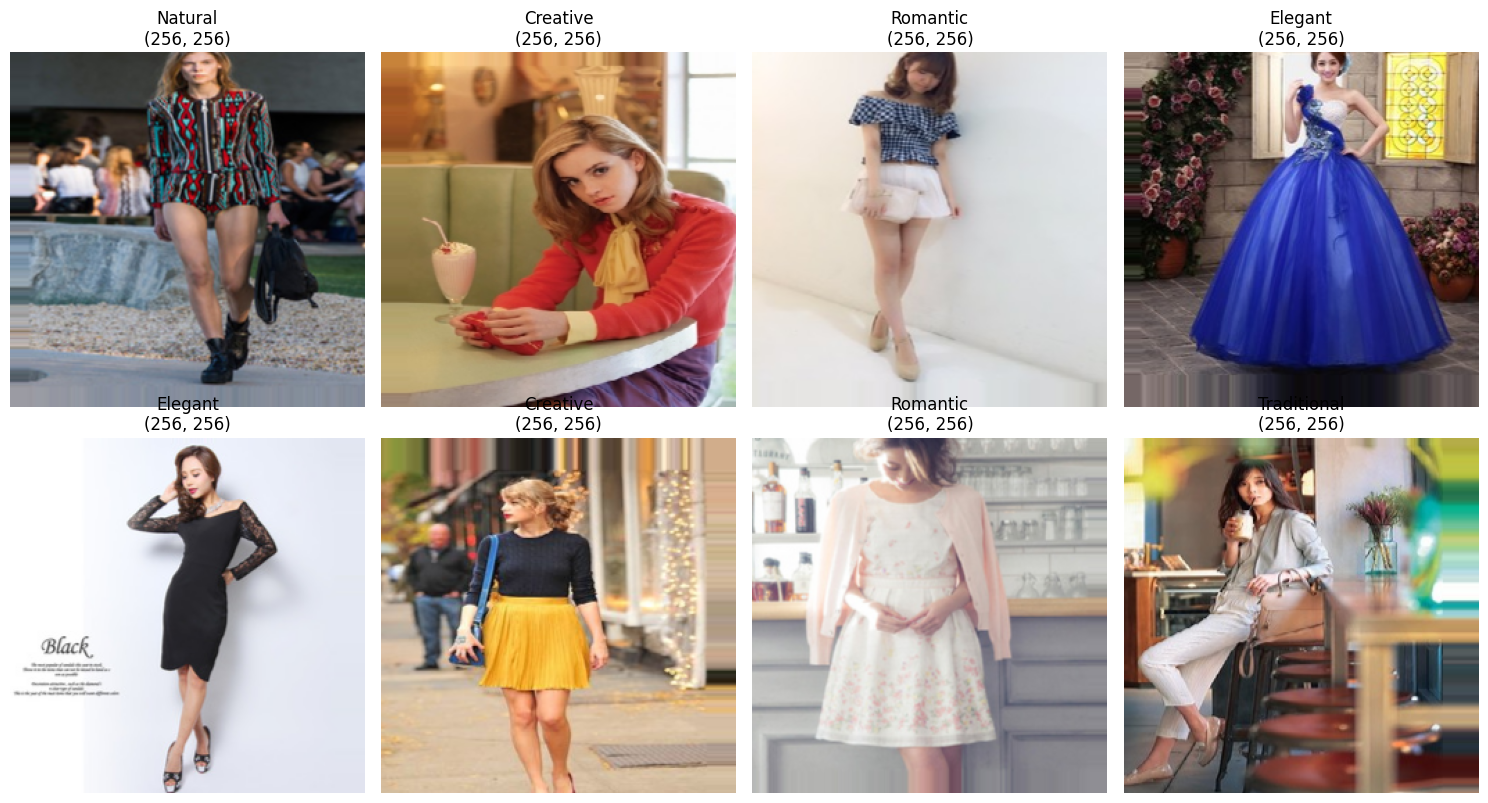

In [ ]:
# ============================================================================
# VER IMÁGENES DEL BATCH DE ENTRENAMIENTO
# ============================================================================

def ver_batch_entrenamiento(generator, class_names, num_imagenes=8):
    """Muestra un batch del generador de entrenamiento"""

    # Obtener un batch
    images_batch, labels_batch = next(generator)

    print(f"📊 BATCH INFO:")
    print(f"   Forma imágenes: {images_batch.shape}")
    print(f"   Forma labels: {labels_batch.shape}")
    print(f"   Rango píxeles: {images_batch.min():.3f} - {images_batch.max():.3f}")

    # Mostrar imágenes
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.flatten()

    for i in range(min(num_imagenes, len(images_batch))):
        # Obtener clase real
        clase_idx = np.argmax(labels_batch[i])
        clase_nombre = class_names[clase_idx]

        # Mostrar imagen
        axes[i].imshow(images_batch[i])
        axes[i].set_title(f'{clase_nombre}\n{images_batch[i].shape[:2]}')
        axes[i].axis('off')

    # Ocultar ejes sobrantes
    for i in range(len(images_batch), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    return images_batch, labels_batch

# USAR: (después de crear train_generator)
print("👀 VISUALIZANDO BATCH DE ENTRENAMIENTO...")
images, labels = ver_batch_entrenamiento(train_generator, class_names, num_imagenes=8)

In [ ]:
# ============================================================================
# 2.1 CALCULAR CLASS WEIGHTS
# ============================================================================

from sklearn.utils.class_weight import compute_class_weight

print("⚖️ CALCULANDO CLASS WEIGHTS...")
y_train = train_df['label'].values
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)

class_weight_dict = {}
for i, clase in enumerate(classes):
    class_weight_dict[i] = class_weights[i]
    print(f"   {clase}: {class_weights[i]:.2f}")

print("✅ Class weights calculados")

⚖️ CALCULANDO CLASS WEIGHTS...
   Creative: 0.64
   Dramatic: 1.90
   Elegant: 1.13
   Magnetic: 1.76
   Natural: 1.04
   Romantic: 0.56
   Traditional: 1.45
✅ Class weights calculados


In [ ]:
# ============================================================================
# 3. MODELO XCEPTION (ARQUITECTURA EXACTA DEL ARTÍCULO)
# ============================================================================

print("\n🧠 CREANDO MODELO XCEPTION (ARTÍCULO EXACTO)...")
print("="*60)

# Limpiar sesión anterior
tf.keras.backend.clear_session()

# Modelo base EXACTO como el artículo
base_model = Xception(
    weights= "imagenet",
    include_top=False,
    input_shape=input_shape,
)

for layer in base_model.layers:
    layer.trainable = False

# CONGELAR CAPAS EXACTO como el artículo
"""for layer in base_model.layers:
    layer.trainable = False
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True"""

# Descongelar las últimas 20 capas
for layer in base_model.layers[-20:]:
    layer.trainable = True

# ARQUITECTURA
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='linear',dtype='float32')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# COMPILACIÓN EXACTA del artículo
model.compile(
    optimizer=Adam(learning_rate=learning_rate),  # lr=0.01 exacto
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),# Loss exacto
    metrics=['accuracy']
)

print("✅ MODELO EXACTO DEL ARTÍCULO CREADO")
print(f"   Optimizer: Adam (lr={learning_rate})")
print(f"   Loss: Categorical cross-entropy")
print(f"   Input shape: {input_shape}")


🧠 CREANDO MODELO XCEPTION (ARTÍCULO EXACTO)...
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ MODELO EXACTO DEL ARTÍCULO CREADO
   Optimizer: Adam (lr=0.01)
   Loss: Categorical cross-entropy
   Input shape: (256, 256, 3)


In [ ]:
# ============================================================================
# 4. ENTRENAMIENTO (EXACTO AL ARTÍCULO)
# ============================================================================

print("\n🎯 INICIANDO ENTRENAMIENTO...")
print("="*60)
print(f"Épocas: {epochs}, Batch size: {batch_size}")

# QUITAR TODOS LOS CALLBACKS - Entrenamiento exacto como el artículo
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    verbose=1,
    class_weight=class_weight_dict,
)


🎯 INICIANDO ENTRENAMIENTO...
Épocas: 50, Batch size: 32


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 214s 975ms/step - accuracy: 0.4481 - loss: 1.4453 - val_accuracy: 0.5345 - val_loss: 6.2211
Epoch 2/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 121s 678ms/step - accuracy: 0.7003 - loss: 0.7893 - val_accuracy: 0.5682 - val_loss: 2.1948
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 120s 675ms/step - accuracy: 0.7828 - loss: 0.5807 - val_accuracy: 0.6315 - val_loss: 1.3505
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 119s 670ms/step - accuracy: 0.8095 - loss: 0.4713 - val_accuracy: 0.7525 - val_loss: 0.8170
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 117s 658ms/step - accuracy: 0.8511 - loss: 0.3767 - val_accuracy: 0.7834 - val_loss: 0.7599
Epoch 6/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 118s 662ms/step - accuracy: 0.8747 - loss: 0.3030 - val_accuracy: 0.7932 - val_loss: 0.7531
Epoch 7/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 124s 693ms/step - accuracy: 0.9143 - loss: 0.2167 - val_accuracy: 0.7637 - val_loss: 1.2808
Epoch 8/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 124s 692ms/step - accuracy: 0.9035 -

In [ ]:
# ============================================================================
# 5. EVALUACIÓN (EXACTA AL ARTÍCULO)
# ============================================================================

print("\n📊 EVALUANDO MODELO...")
print("="*60)

# Evaluación en test set
test_results = model.evaluate(test_generator, verbose=1)
test_loss, test_accuracy = test_results[0], test_results[1]

print(f"📈 RESULTADOS EN TEST SET:")
print(f"   Loss: {test_loss:.4f}")
print(f"   Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


📊 EVALUANDO MODELO...
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 934ms/step - accuracy: 0.7978 - loss: 1.0505
📈 RESULTADOS EN TEST SET:
   Loss: 1.1881
   Accuracy: 0.7935 (79.35%)


In [ ]:
# ============================================================================
# 6. PREDICCIONES Y MATRIZ DE CONFUSIÓN (EXACTO AL ARTÍCULO)
# ============================================================================

print("\n🎯 GENERANDO PREDICCIONES...")

# Obtener predicciones
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

print("\n📋 MATRIZ DE CONFUSIÓN:")
print(cm)


🎯 GENERANDO PREDICCIONES...
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 663ms/step

📋 MATRIZ DE CONFUSIÓN:
[[136   7   2   5   1   8   0]
 [  9  42   0   2   0   0   0]
 [  6   0  77   3   0   4   0]
 [  5  11   0  40   0   2   0]
 [  8   2   2   1  76   6   3]
 [ 20   2   1   5   2 152   1]
 [  5   1   0   6   1  16  42]]


In [ ]:
# ============================================================================
# 7. MÉTRICAS DETALLADAS (EXACTO AL ARTÍCULO)
# ============================================================================

print("\n📊 MÉTRICAS DETALLADAS POR CLASE:")
print("="*60)

# Reporte de clasificación
report = classification_report(y_true, y_pred_classes, target_names=class_names, digits=4)
print(report)

# Precisión por clase
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\n🎯 PRECISIÓN POR CLASE:")
for i, class_name in enumerate(class_names):
    print(f"   {class_name}: {class_accuracy[i]:.4f} ({class_accuracy[i]*100:.2f}%)")

print(f"\n📊 PRECISIÓN PROMEDIO: {np.mean(class_accuracy):.4f} ({np.mean(class_accuracy)*100:.2f}%)")


📊 MÉTRICAS DETALLADAS POR CLASE:
              precision    recall  f1-score   support

    Creative     0.7196    0.8553    0.7816       159
    Dramatic     0.6462    0.7925    0.7119        53
     Elegant     0.9390    0.8556    0.8953        90
    Magnetic     0.6452    0.6897    0.6667        58
     Natural     0.9500    0.7755    0.8539        98
    Romantic     0.8085    0.8306    0.8194       183
 Traditional     0.9130    0.5915    0.7179        71

    accuracy                         0.7935       712
   macro avg     0.8031    0.7701    0.7781       712
weighted avg     0.8097    0.7935    0.7948       712


🎯 PRECISIÓN POR CLASE:
   Creative: 0.8553 (85.53%)
   Dramatic: 0.7925 (79.25%)
   Elegant: 0.8556 (85.56%)
   Magnetic: 0.6897 (68.97%)
   Natural: 0.7755 (77.55%)
   Romantic: 0.8306 (83.06%)
   Traditional: 0.5915 (59.15%)

📊 PRECISIÓN PROMEDIO: 0.7701 (77.01%)


In [ ]:
# ============================================================================
# 8. COMPARACIÓN CON RESULTADOS DEL ARTÍCULO
# ============================================================================

print("\n📚 COMPARACIÓN CON ARTÍCULO ORIGINAL:")
print("="*60)
print("Artículo - XCEPTION:")
print("   Error: 0.2267")
print("   Accuracy: 0.9827 (98.27%)")
print(f"\nNuestro resultado:")
print(f"   Error: {test_loss:.4f}")
print(f"   Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

diferencia_accuracy = test_accuracy - 0.9827
print(f"\n📊 DIFERENCIA: {diferencia_accuracy:.4f} ({diferencia_accuracy*100:.2f}%)")


📚 COMPARACIÓN CON ARTÍCULO ORIGINAL:
Artículo - XCEPTION:
   Error: 0.2267
   Accuracy: 0.9827 (98.27%)

Nuestro resultado:
   Error: 1.1881
   Accuracy: 0.7935 (79.35%)

📊 DIFERENCIA: -0.1892 (-18.92%)



📈 GENERANDO GRÁFICOS...


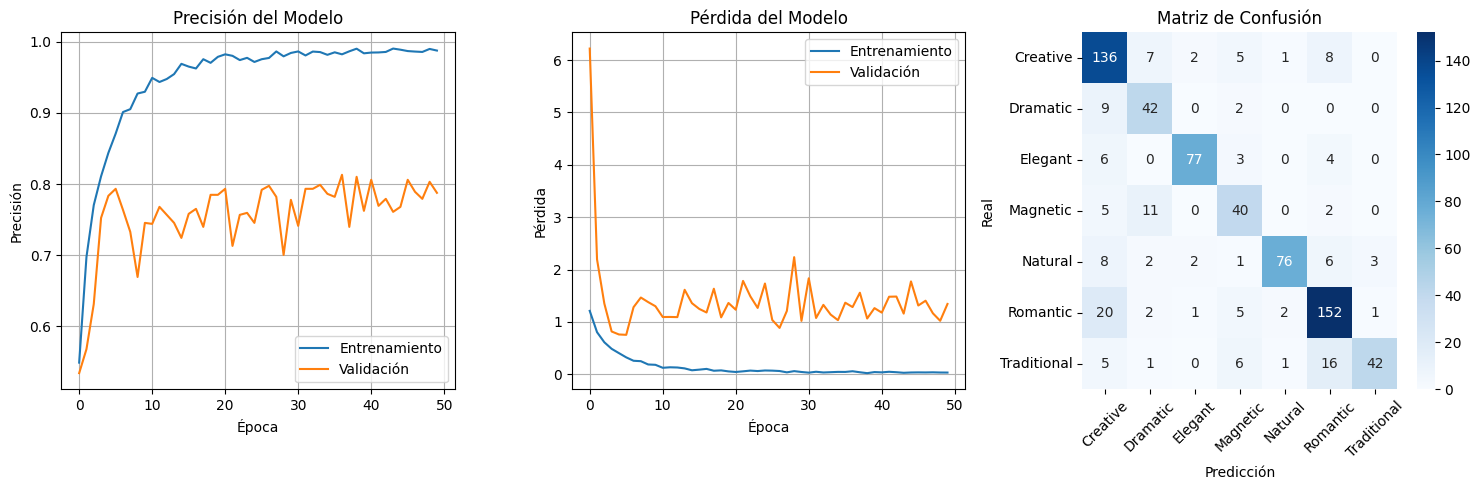

In [ ]:
# ============================================================================
# 9. VISUALIZACIONES
# ============================================================================

print("\n📈 GENERANDO GRÁFICOS...")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del Modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del Modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# 10. GUARDAR MODELO
# ============================================================================

print("\n💾 GUARDANDO MODELO...")
model.save(os.path.join(base_dir, 'xception_7styles_256_256_3_linear_20_classbalanced.h5'))
print("✅ Modelo guardado como 'xception_7styles_256_256_3_linear_20_classbalanced.h5'")

print(f"\n🎉 ENTRENAMIENTO COMPLETADO EN {len(history.history['loss'])} ÉPOCAS")
print("⚡ Optimizado con mixed precision y multiprocessing")


💾 GUARDANDO MODELO...
✅ Modelo guardado como 'xception_7styles_256_256_3_linear_20_classbalanced.h5'

🎉 ENTRENAMIENTO COMPLETADO EN 50 ÉPOCAS
⚡ Optimizado con mixed precision y multiprocessing
